# Data and Libraries

## Libraries

In [1]:
!pip install -q yfinance
!pip install -q pandas pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
from scipy.optimize import minimize, basinhopping, brentq
from scipy.stats import norm
from scipy.special import gammaln
from scipy.interpolate import griddata
import math
from mpl_toolkits.mplot3d import Axes3D
import yfinance as yf
import pandas_datareader.data as web

import warnings
warnings.filterwarnings("ignore")

## Data

In [3]:

# Collected - 17/7/24 21:34
S = 5588.27
imp_vol = 0.1263
hist_vol = 0.0819

K7 = [i for i in range(5540, 5635 + 1 , 5)]
c7 = [69.0, 65.35, 61.8, 58.2, 54.75, 51.45, 48.25, 45.2, 42.25, 39.35, 36.6, 34.0, 31.45, 29.05, 26.7, 24.55, 22.5, 20.5, 18.7, 17]
p7 = [15.75,17.05,18.5,20.0,21.6,23.3,25.1,27.0,29.0,31.15,33.4,35.8,38.2,40.75,43.5,46.35,49.25,52.25,55.45,58.75]

K30 = [5510,5520,5525,5530,5540,5550,5560,5570,5575,5580,5590,5600,5610,5620,5625,5630,5640,5650,5660,5670]
c30 = [140.75,133.35,129.6,126.35,119.15,112.30,105.50,98.80,95.60,92.55,86.25,80.45,74.75,69.25,66.65,64.05,59.05,54.35,49.85,45.65]
p30 = [40.75,43.40,44.7,46.0,48.8,51.8,54.95,58.3,60.05,61.85,65.65,69.65,73.95,78.4,80.75,83.1,88.1,93.25,98.75,104.5]

K95 = [i for i in range(5540, 5635 + 1, 5)]
c95 = [216.3,213.0,209.2,205.8,202.3,198.9,195.75,192.1,188.7,185.4,182.1,178.85,175.85,172.35,169.15,166.05,162.9,159.8,156.8,153.7]
p95 = [96.45,97.85,99.25,100.65,102.15,103.65,105.2,106.75,108.3,109.9,111.5,113.2,114.85,116.6,118.3,120.1,121.9,123.7,125.5,127.4]

start = "1980-07-17"
end="2024-07-17"

data = yf.download("SPY",start=start, end=end, interval="1d", actions=True)
data.index = pd.to_datetime(data.index, format = '%d/%m/%Y')
prices = data["Close"]
ratios = prices / prices.shift(1)
ratios.dropna(inplace=True)
log_returns = np.log(ratios).values


df = web.DataReader('DFF', 'fred', "2024-07-15", "2024-07-17")
r = np.mean(df["DFF"])/100
print("Risk-Free Rate (1-Month Treasury):", r)

dividends = data["Dividends"]
annual_dividends = dividends.resample('Y').sum().iloc[-1]
current_price = data["Close"].iloc[-1]
q = (annual_dividends / current_price).values.item()

print("Dividend Yield (q):", q)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Risk-Free Rate (1-Month Treasury): 0.0533
Dividend Yield (q): 0.005976013485848439


# Option Pricing Formulae

In [4]:
def black_scholes_call(S, K, T, r, q, sigma):
    """Vectorized Black-Scholes formula for European call options."""
    K = np.array(K)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def merton_jump_call(S, K, T, r, q, sigma, lambd, mu_J, sigma_J, max_k=30):
    """Vectorized Merton jump-diffusion model for European call options."""
    price = np.zeros_like(K, dtype=float)
    K = np.array(K)
    for k in range(max_k + 1):
        # Poisson probability (log to avoid large factorials)
        log_poisson = -lambd * T + k * np.log(lambd * T) - np.log(np.math.factorial(k))
        poisson_prob = np.exp(log_poisson)
        
        # Adjusted parameters
        adj_sigma = np.sqrt(sigma**2 + (k * sigma_J**2) / T)
        adj_r = r - lambd * (np.exp(mu_J + 0.5 * sigma_J**2) - 1) + (k * (mu_J + 0.5 * sigma_J**2)) / T
        
        # Black-Scholes component
        bs_price = black_scholes_call(S, K, T, adj_r, q, adj_sigma)
        price += poisson_prob * bs_price
        
        if poisson_prob < 1e-10:
            break
    return price

def kou_jump_call(S, K, T, r, q, sigma, lamb, p, eta1, eta2, max_k=30):
    """Vectorized Kou double exponential jump-diffusion model for European call options."""

    K = np.array(K)
    sigma = np.array(sigma)
    
    price = np.zeros_like(K, dtype=float)
    for k in range(max_k + 1):
        log_poisson = -lamb * T + k * np.log(lamb * T) - np.log(np.math.factorial(k))
        poisson_prob = np.exp(log_poisson)
        
        # Adjusted parameters
        total_var = sigma**2 * T + k * (2 * p / eta1**2 + 2 * (1 - p) / eta2**2)
        
        # Skip if any element of total_var is <= 0
        if np.any(total_var <= 0):
            continue
            
        total_vol = np.sqrt(total_var)
        drift_term = (r - q - 0.5 * sigma**2 - lamb * (p * eta1 / (eta1 - 1) + (1 - p) * eta2 / (eta2 + 1) - 1)) * T
        
        d1 = (np.log(S / K) + drift_term + 0.5 * total_var) / total_vol
        d2 = d1 - total_vol
        
        # Clip to avoid overflow in norm.cdf
        d1 = np.clip(d1, -10, 10)
        d2 = np.clip(d2, -10, 10)
        
        term1 = S * np.exp(-q * T + drift_term) * norm.cdf(d1)
        term2 = K * np.exp(-r * T) * norm.cdf(d2)
        price += poisson_prob * (term1 - term2)
        
        if poisson_prob < 1e-10:
            break
    return price

# Parameter Estimation using Historical Data

In [5]:

mean_log_return = np.mean(log_returns)
std_log_return = np.std(log_returns)

# Use last years data to estimate volatility
sigma_log_returns = log_returns[-365:]
sigma_hat = np.std(sigma_log_returns) * np.sqrt(252)

threshold_up = mean_log_return + 5.5  * std_log_return
threshold_down = mean_log_return - 5.5 * std_log_return

jumps = log_returns[(log_returns > threshold_up) | (log_returns < threshold_down)]

jumps_up = log_returns[log_returns > threshold_up]
jumps_down = log_returns[log_returns < threshold_down]

jump_count = len(jumps_up) + len(jumps_down)

lambd_opt = jump_count / (len(log_returns)/252)  # Estimated jump intensity
p_opt = len(jumps_up) / jump_count               # Probability of upward jump
eta1_opt = 1/np.mean(jumps_up)                   # Rate of upward jumps
eta2_opt = 1/-np.mean(jumps_down)                # Rate of downward jumps

k_opt = np.mean(jumps)                           # Mean jump size
delta_opt = np.std(jumps)                        # Volatility of jump size

# Initial Guess is historical estimates
initial_guess_merton = [sigma_hat, lambd_opt, k_opt, delta_opt]
initial_guess_kou = [sigma_hat, lambd_opt, p_opt, eta1_opt, eta2_opt]

print("Annual volatility (σ):", sigma_hat)
print("\nKou Params:")
print("annual jump rate (λ):",lambd_opt,"\nprobability of upward jump (p):", p_opt, "\nmagnitude of upward jump (1/η1):", 1/eta1_opt,"\nmagnitude of upward jump (1/η2):", 1/eta2_opt, "\n")
print("Merton Params:")
print("annual jump rate (λ):", lambd_opt, "\nmean jump size (μJ):", k_opt, "\njump volatility (σJ) :",delta_opt)

Annual volatility (σ): 0.1192403537574142

Kou Params:
annual jump rate (λ): 0.5727272727272728 
probability of upward jump (p): 0.3333333333333333 
magnitude of upward jump (1/η1): 0.09186933133607827 
magnitude of upward jump (1/η2): 0.08400824660862943 

Merton Params:
annual jump rate (λ): 0.5727272727272728 
mean jump size (μJ): -0.02538238729372686 
jump volatility (σJ) : 0.08496939234124158


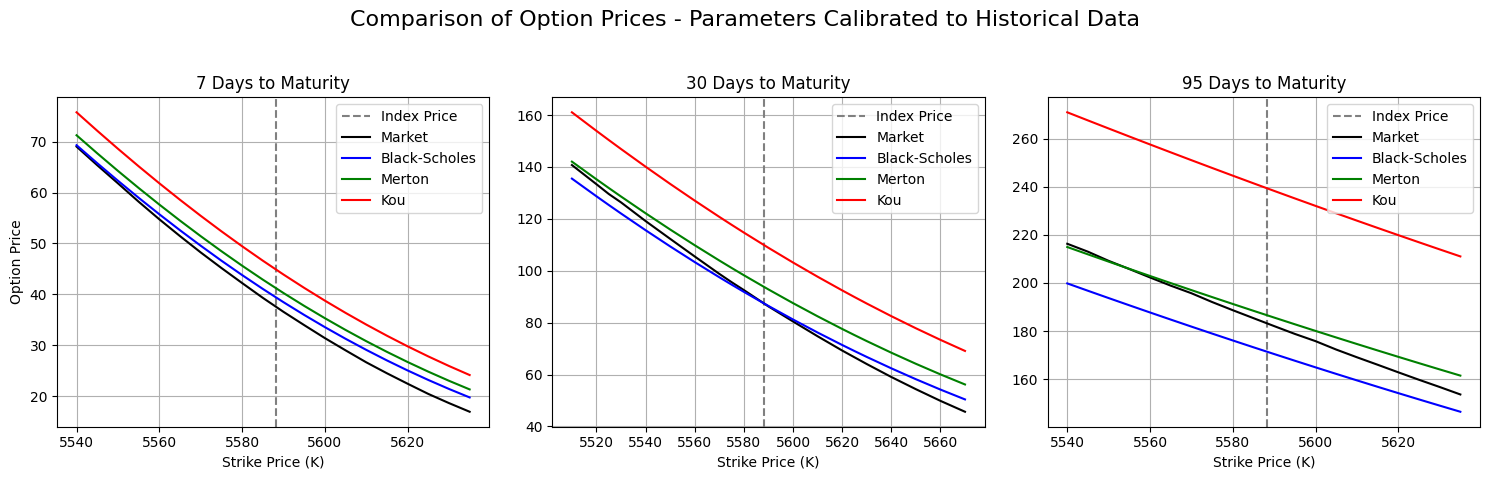

Mean Squared Errors for 7 Days:
Black-Scholes: 3.6077192370367532
Merton: 12.799915537090463
Kou: 51.55184472939318

Mean Squared Errors for 30 Days:
Black-Scholes: 10.108078651869711
Merton: 45.84581291235329
Kou: 494.274011013002

Mean Squared Errors for 95 Days:
Black-Scholes: 149.333508297839
Merton: 18.391080516170877
Kou: 3137.1661942437777


In [6]:

# Calculate prices for 7 days to maturity
bs_prices_7 = [black_scholes_call(S, k, 7/365, r, q, sigma_hat) for k in K7]
merton_prices_7 = [merton_jump_call(S, k, 7/365, r, q, *initial_guess_merton) for k in K7]
kou_prices_7 = [kou_jump_call(S, k, 7/365, r, q, *initial_guess_kou) for k in K7]

# Calculate prices for 30 days to maturity
bs_prices_30 = [black_scholes_call(S, k, 30/365, r, q, sigma_hat) for k in K30]
merton_prices_30 = [merton_jump_call(S, k, 30/365, r, q, *initial_guess_merton) for k in K30]
kou_prices_30 = [kou_jump_call(S, k, 30/365, r, q, *initial_guess_kou) for k in K30]

# Calculate prices for 95 days to maturity
bs_prices_95 = [black_scholes_call(S, k, 95/365, r, q, sigma_hat) for k in K95]
merton_prices_95 = [merton_jump_call(S, k, 95/365, r, q, *initial_guess_merton) for k in K95]
kou_prices_95 = [kou_jump_call(S, k, 95/365, r, q, *initial_guess_kou) for k in K95]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 7 days to maturity
axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

# Plot for 30 days to maturity
axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

# Plot for 95 days to maturity
axs[2].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[2].plot(K95, c95, label="Market", color='black')
axs[2].plot(K95, bs_prices_95, label="Black-Scholes", color='blue')
axs[2].plot(K95, merton_prices_95, label="Merton", color='green')
axs[2].plot(K95, kou_prices_95, label="Kou", color='red')
axs[2].set_title("95 Days to Maturity")
axs[2].set_xlabel("Strike Price (K)")
axs[2].legend()
axs[2].grid(True)

fig.suptitle("Comparison of Option Prices - Parameters Calibrated to Historical Data", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculating and Printing MSEs for each maturity
print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")

print("\nMean Squared Errors for 95 Days:")
print(f"Black-Scholes: {mean_squared_error(c95, bs_prices_95)}")
print(f"Merton: {mean_squared_error(c95, merton_prices_95)}")
print(f"Kou: {mean_squared_error(c95, kou_prices_95)}")

# Calibrating Parameters to Market Price

## Calibration Functions

In [7]:
# Objective Functions
def objective_function_black_scholes(params, S, K, T, r, q, market_prices, weights):
    """Weighted objective function for Black-Scholes calibration."""
    sigma = params
    if sigma <= 0:
        return np.inf  # Penalise invalid parameters
    
    model_prices = black_scholes_call(S, K, T, r, q, sigma)
    error = np.sum(weights * (model_prices - market_prices) ** 2)
    return error

def objective_function_merton(params, S, K, T, r, q, market_prices, weights):
    """Weighted objective function for Merton calibration."""
    sigma, lambd, mu_J, sigma_J = params
    if sigma <= 0 or lambd <= 0 or sigma_J <= 0:
        return np.inf  # Penalize invalid parameters
    
    model_prices = merton_jump_call(S, K, T, r, q, sigma, lambd, mu_J, sigma_J)
    error = np.sum(weights * (model_prices - market_prices) ** 2)
    return error

def objective_function_kou(params, S, K, T, r, q, market_prices, weights):
    """Weighted objective function for Kou calibration."""
    sigma, lamb, p, eta1, eta2 = params
    if sigma <= 0 or lamb <= 0 or p <= 0 or p >= 1 or eta1 <= 1 or eta2 <= 0:
        return np.inf  # Penalize invalid parameters
    
    model_prices = kou_jump_call(S, K, T, r, q, sigma, lamb, p, eta1, eta2)
    error = np.sum(weights * (model_prices - market_prices) ** 2)
    return error

# Hybrid Calibration Functions
def calibrate_black_scholes_params(S, K, T, r, q, market_prices, initial_guess, weights=None):
    """Hybrid calibration for Black-Scholes model."""
    if weights is None:
        weights = np.ones_like(market_prices)  # Equal weighting
    
    bounds = [(1e-5, 1.0)]  # sigma > 0
    
    # Use basin-hopping for global optimization (few iterations)
    result_global = basinhopping(
        objective_function_black_scholes,
        initial_guess,
        minimizer_kwargs={
            "args": (S, K, T, r, q, market_prices, weights),
            "method": "L-BFGS-B",
            "bounds": bounds,
        },
        niter=10,  # Fewer iterations for speed
        stepsize=0.1,
    )
    
    # Use local optimization for fine-tuning
    result_local = minimize(
        objective_function_black_scholes,
        result_global.x,
        args=(S, K, T, r, q, market_prices, weights),
        method="L-BFGS-B",
        bounds=bounds,
    )
    
    return result_local.x

def calibrate_merton_params(S, K, T, r, q, market_prices, initial_guess, weights=None):
    """Hybrid calibration for Merton model."""
    if weights is None:
        weights = np.ones_like(market_prices)  # Equal weighting
    
    bounds = [
        (1e-5, 1.0),   # sigma > 0
        (1e-5, 1.0),  # lambda > 0
        (-1.0, 1.0),    # mu_J ∈ [-1, 1]
        (0.05, 1.0)     # sigma_J > 0
    ]
    
    # Use basin-hopping for global optimization (few iterations)
    result_global = basinhopping(
        objective_function_merton,
        initial_guess,
        minimizer_kwargs={
            "args": (S, K, T, r, q, market_prices, weights),
            "method": "L-BFGS-B",
            "bounds": bounds,
        },
        niter=10,  # Fewer iterations for speed
        stepsize=0.1,
    )
    
    # Use local optimization for fine-tuning
    result_local = minimize(
        objective_function_merton,
        result_global.x,
        args=(S, K, T, r, q, market_prices, weights),
        method="L-BFGS-B",
        bounds=bounds,
    )
    
    return result_local.x

def calibrate_kou_params(S, K, T, r, q, market_prices, initial_guess, weights=None):
    """Hybrid calibration for Kou model."""
    if weights is None:
        weights = np.ones_like(market_prices)  # Equal weighting
    
    bounds = [
        (1e-5, 1.0),   # sigma > 0
        (1e-5, 1.0),  # lambda > 0
        (0.2, 0.8),  # p ∈ (0, 1)
        (1.01, 20.0),  # eta1 > 1
        (1e-5, 20.0)   # eta2 > 0
    ]
    
    # Use basin-hopping for global optimization (few iterations)
    result_global = basinhopping(
        objective_function_kou,
        initial_guess,
        minimizer_kwargs={
            "args": (S, K, T, r, q, market_prices, weights),
            "method": "L-BFGS-B",
            "bounds": bounds,
        },
        niter=10,  # Fewer iterations for speed
        stepsize=0.1,
    )
    
    # Use local optimization for fine-tuning
    result_local = minimize(
        objective_function_kou,
        result_global.x,
        args=(S, K, T, r, q, market_prices, weights),
        method="L-BFGS-B",
        bounds=bounds,
    )
    
    return result_local.x

## Parameter Values

In [8]:

price_calibrated_bs_7 = calibrate_black_scholes_params(S, K7, 7/365, r, q, c7, sigma_hat)
price_calibrated_bs_30 = calibrate_black_scholes_params(S, K7, 30/365, r, q, c30, sigma_hat)
price_calibrated_bs_95 = calibrate_black_scholes_params(S, K7, 95/365, r, q, c95, sigma_hat)

price_calibrated_merton_7 = calibrate_merton_params(S, K7, 7/365, r, q, c7, initial_guess_merton)
price_calibrated_merton_30 = calibrate_merton_params(S, K30, 30/365, r, q, c30, initial_guess_merton)
price_calibrated_merton_95 = calibrate_merton_params(S, K95, 95/365, r, q, c95, initial_guess_merton)

price_calibrated_kou_7 = calibrate_kou_params(S, K7, 7/365, r, q, c7, initial_guess_kou)
price_calibrated_kou_30 = calibrate_kou_params(S, K30, 30/365, r, q, c30, initial_guess_kou)
price_calibrated_kou_95 = calibrate_kou_params(S, K95, 95/365, r, q, c95, initial_guess_kou)

print("7 DAY ","-"*100)
print("Black Scholes Param: \nVolatility:", price_calibrated_bs_7.item(), "\n")
print("Kou Params:")
print("volatility (σ):", price_calibrated_kou_7[0], "\nannual jump rate (λ):",price_calibrated_kou_7[1],"\nprobability of upward jump (p):", price_calibrated_kou_7[2], "\ninverse magnitude of upward jump (η1):", price_calibrated_kou_7[3],"\ninverse magnitude of upward jump (η2):", price_calibrated_kou_7[4], "\n")
print("Merton Params:")
print("volatility (σ):", price_calibrated_merton_7[0], "\nannual jump rate (λ):", price_calibrated_merton_7[1], "\nmean jump size (μJ):", price_calibrated_merton_7[2], "\njump volatility (σJ) :",price_calibrated_merton_7[3])

print("\n30 DAY","-"*100)
print("Black Scholes Param: \nVolatility:", price_calibrated_bs_30.item(), "\n")
print("Kou Params:")
print("volatility (σ):", price_calibrated_kou_30[0],"\nannual jump rate (λ):",price_calibrated_kou_30[1],"\nprobability of upward jump (p):", price_calibrated_kou_30[2], "\ninverse magnitude of upward jump (η1):", price_calibrated_kou_30[3],"\ninverse magnitude of upward jump (η2):", price_calibrated_kou_30[4], "\n")
print("Merton Params:")
print("volatility (σ):", price_calibrated_merton_30[0], "\nannual jump rate (λ):", price_calibrated_merton_30[1], "\nmean jump size (μJ):", price_calibrated_merton_30[2], "\njump volatility (σJ) :",price_calibrated_merton_30[3])

print("\n95 DAY","-"*100)
print("Black Scholes Param: \nVolatility:", price_calibrated_bs_95.item(), "\n")
print("Kou Params:")
print("volatility (σ):", price_calibrated_kou_95[0],"\nannual jump rate (λ):",price_calibrated_kou_95[1],"\nprobability of upward jump (p):", price_calibrated_kou_95[2], "\ninverse magnitude of upward jump (η1):", price_calibrated_kou_95[3],"\ninverse magnitude of upward jump (η2):", price_calibrated_kou_95[4], "\n")
print("Merton Params:")
print("volatility (σ):", price_calibrated_merton_95[0], "\nannual jump rate (λ):", price_calibrated_merton_95[1], "\nmean jump size (μJ):", price_calibrated_merton_95[2], "\njump volatility (σJ) :",price_calibrated_merton_95[3])

7 DAY  ----------------------------------------------------------------------------------------------------
Black Scholes Param: 
Volatility: 0.11331073914580525 

Kou Params:
volatility (σ): 0.10391902297475347 
annual jump rate (λ): 0.03232065257572461 
probability of upward jump (p): 0.2 
inverse magnitude of upward jump (η1): 13.3277653149967 
inverse magnitude of upward jump (η2): 7.258992494080082 

Merton Params:
volatility (σ): 0.1029441681788728 
annual jump rate (λ): 0.7687188866665322 
mean jump size (μJ): -0.08351751861519788 
jump volatility (σJ) : 0.05

30 DAY ----------------------------------------------------------------------------------------------------
Black Scholes Param: 
Volatility: 0.12133271604385049 

Kou Params:
volatility (σ): 0.0964551714032338 
annual jump rate (λ): 0.19507527841400327 
probability of upward jump (p): 0.2 
inverse magnitude of upward jump (η1): 20.0 
inverse magnitude of upward jump (η2): 20.0 

Merton Params:
volatility (σ): 0.0914946675

## Estimated Prices

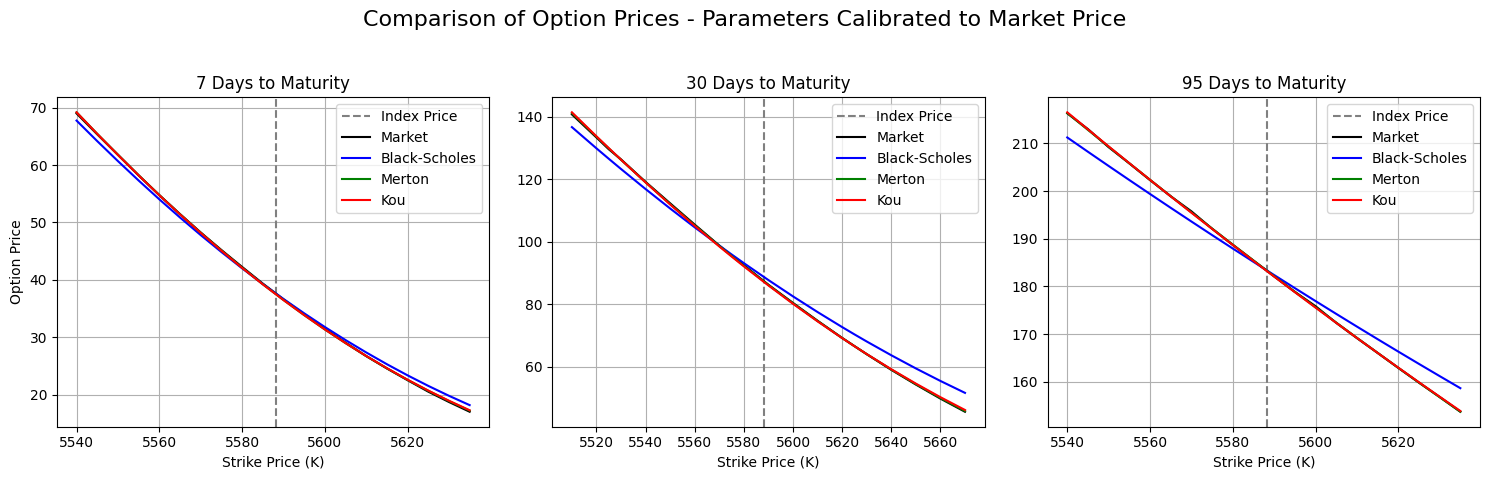

Mean Squared Errors for 7 Days:
Black-Scholes: 0.5879076909129912
Merton: 0.01146195553846004
Kou: 0.016721991271731455

Mean Squared Errors for 30 Days:
Black-Scholes: 11.51435123129258
Merton: 0.03288886428588796
Kou: 0.11224084381424118

Mean Squared Errors for 95 Days:
Black-Scholes: 9.381295739047193
Merton: 0.009032144348016597
Kou: 0.01573882855436248


In [9]:

# Calculate prices for 7 days to maturity
bs_prices_7 = [black_scholes_call(S, k, 7/365, r, q, price_calibrated_bs_7) for k in K7]
merton_prices_7 = [merton_jump_call(S, k, 7/365, r, q, *price_calibrated_merton_7) for k in K7]
kou_prices_7 = [kou_jump_call(S, k, 7/365, r, q, *price_calibrated_kou_7) for k in K7]

# Calculate prices for 30 days to maturity
bs_prices_30 = [black_scholes_call(S, k, 30/365, r, q, price_calibrated_bs_30) for k in K30]
merton_prices_30 = [merton_jump_call(S, k, 30/365, r, q, *price_calibrated_merton_30) for k in K30]
kou_prices_30 = [kou_jump_call(S, k, 30/365, r, q, *price_calibrated_kou_30) for k in K30]

# Calculate prices for 95 days to maturity
bs_prices_95 = [black_scholes_call(S, k, 95/365, r, q, price_calibrated_bs_95) for k in K95]
merton_prices_95 = [merton_jump_call(S, k, 95/365, r, q, *price_calibrated_merton_95) for k in K95]
kou_prices_95 = [kou_jump_call(S, k, 95/365, r, q, *price_calibrated_kou_95) for k in K95]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 7 days to maturity
axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

# Plot for 30 days to maturity
axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

# Plot for 95 days to maturity
axs[2].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[2].plot(K95, c95, label="Market", color='black')
axs[2].plot(K95, bs_prices_95, label="Black-Scholes", color='blue')
axs[2].plot(K95, merton_prices_95, label="Merton", color='green')
axs[2].plot(K95, kou_prices_95, label="Kou", color='red')
axs[2].set_title("95 Days to Maturity")
axs[2].set_xlabel("Strike Price (K)")
axs[2].legend()
axs[2].grid(True)

fig.suptitle("Comparison of Option Prices - Parameters Calibrated to Market Price", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculating and Printing MSEs for each maturity
print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")

print("\nMean Squared Errors for 95 Days:")
print(f"Black-Scholes: {mean_squared_error(c95, bs_prices_95)}")
print(f"Merton: {mean_squared_error(c95, merton_prices_95)}")
print(f"Kou: {mean_squared_error(c95, kou_prices_95)}")

# Calculating Implied Model Volatilities (IVs)

## Estimating IVs (Using Historically Estimated Parameters)

In [10]:
def bs_implied_volatility(S, K, T, r, q, market_price):
    """Compute implied volatility using Brent's method."""
    def objective(sigma):
        return black_scholes_call(S, K, T, r, q, sigma) - market_price
    try:
        return brentq(objective, 1e-5, 1.0)  # Search for volatility in [0.00001, 1.0]
    except ValueError:
        return sigma_hat 
        
bs_iv_7 = np.array([bs_implied_volatility(S, K7[i], 7/365, r, q, c7[i]) for i in range(len(K7))])
bs_iv_30 = np.array([bs_implied_volatility(S, K30[i], 30/365, r, q, c30[i]) for i in range(len(K30))])
bs_iv_95 = np.array([bs_implied_volatility(S, K95[i], 95/365, r, q, c95[i]) for i in range(len(K95))])

def merton_implied_volatility(S, K, T, r, q, market_price, lambd, mu_J, sigma_J):
    """Compute implied volatility using Brent's method."""
    def objective(sigma):
        return merton_jump_call(S, K, T, r, q, sigma, lambd, mu_J, sigma_J) - market_price
    try:
        return brentq(objective, 1e-5, 1)  # Search for volatility in [0.00001, 1.0]
    except ValueError:
        return sigma_hat 
        
merton_iv_7 = np.array([merton_implied_volatility(S, K7[i], 7/365, r, q, c7[i], *initial_guess_merton[1:]) for i in range(len(K7))])
merton_iv_30 = np.array([merton_implied_volatility(S, K30[i], 30/365, r, q, c30[i], *initial_guess_merton[1:]) for i in range(len(K30))])
merton_iv_95 = np.array([merton_implied_volatility(S, K95[i], 95/365, r, q, c95[i], *initial_guess_merton[1:]) for i in range(len(K95))])


def kou_implied_volatility(S, K, T, r, q, market_price, lamb, p, eta1, eta2):
    """Compute implied volatility using Brent's method."""
    def objective(sigma):
        return kou_jump_call(S, K, T, r, q, sigma, lamb, p, eta1, eta2) - market_price
    try:
        return brentq(objective, 1e-5, 1)  # Search for volatility in [0.00001, 1.0]
    except ValueError:
        return sigma_hat
        
kou_iv_7 = np.array([kou_implied_volatility(S, K7[i], 7/365, r, q, c7[i], *initial_guess_kou[1:]) for i in range(len(K7))])
kou_iv_30 = np.array([kou_implied_volatility(S, K30[i], 30/365, r, q, c30[i], *initial_guess_kou[1:]) for i in range(len(K30))])
kou_iv_95 = np.array([kou_implied_volatility(S, K95[i], 95/365, r, q, c95[i], *initial_guess_kou[1:]) for i in range(len(K95))])

## Plotting IVs

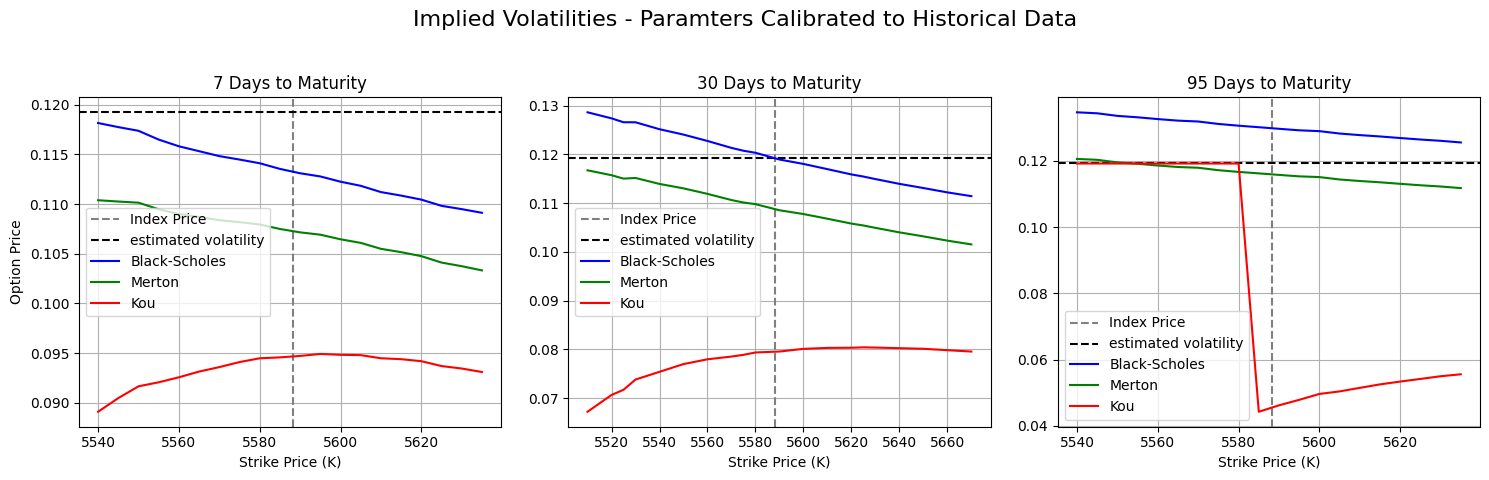

In [11]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 7 days to maturity
axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].axhline(sigma_hat, color='black', linestyle='--', label="estimated volatility")
axs[0].plot(K7, bs_iv_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_iv_7, label="Merton", color='green')
axs[0].plot(K7, kou_iv_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

# Plot for 30 days to maturity
axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].axhline(sigma_hat, color='black', linestyle='--', label="estimated volatility")
axs[1].plot(K30, bs_iv_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_iv_30, label="Merton", color='green')
axs[1].plot(K30, kou_iv_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

# Plot for 95 days to maturity
axs[2].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[2].axhline(sigma_hat, color='black', linestyle='--', label="estimated volatility")
axs[2].plot(K95, bs_iv_95, label="Black-Scholes", color='blue')
axs[2].plot(K95, merton_iv_95, label="Merton", color='green')
axs[2].plot(K95, kou_iv_95, label="Kou", color='red')
axs[2].set_title("95 Days to Maturity")
axs[2].set_xlabel("Strike Price (K)")
axs[2].legend()
axs[2].grid(True)

fig.suptitle("Implied Volatilities - Paramters Calibrated to Historical Data", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Plotting Volatility Surface

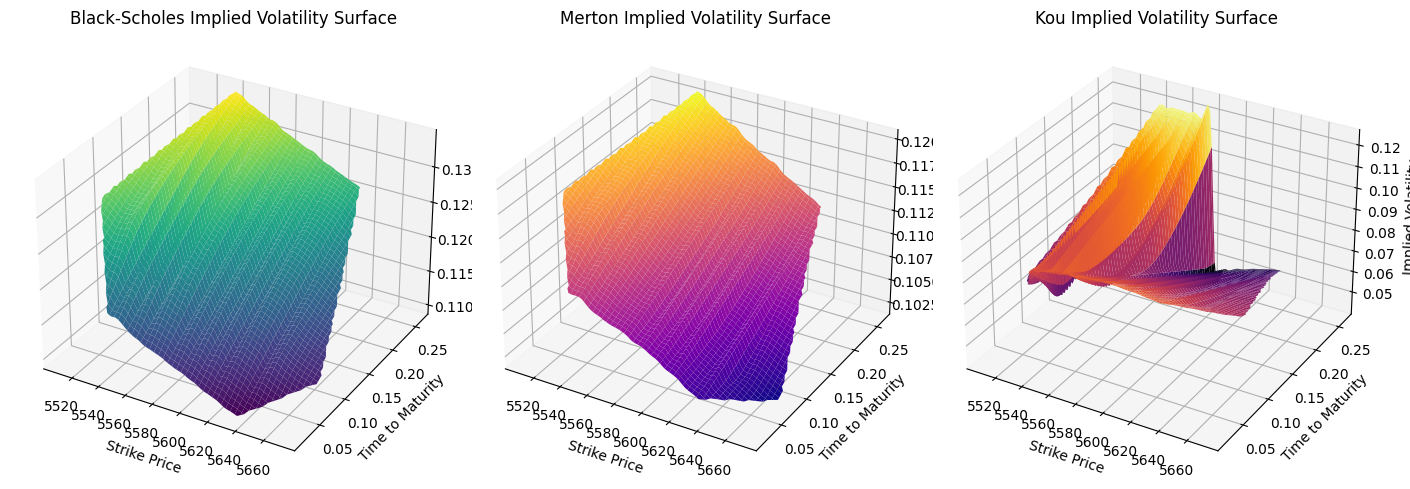

In [12]:

# Combine strike prices and maturities
strikes = np.concatenate([K7, K30, K95])
maturities = np.concatenate([np.full(len(K7), 7/365, dtype=float),np.full(len(K30), 30/365, dtype=float), np.full(len(K95), 95/365, dtype=float)])

# Combine implied volatilities for each model
bs_iv = np.concatenate([bs_iv_7, bs_iv_30, bs_iv_95])
merton_iv = np.concatenate([merton_iv_7, merton_iv_30, merton_iv_95])
kou_iv = np.concatenate([kou_iv_7, kou_iv_30, kou_iv_95])

# Create a grid of strike prices and maturities
strike_grid, maturity_grid = np.meshgrid(np.linspace(strikes.min(), strikes.max(), 100),
                                        np.linspace(maturities.min(), maturities.max(), 100))

# Interpolate implied volatilities for each model
bs_iv_grid = griddata((strikes, maturities), bs_iv, (strike_grid, maturity_grid), method='cubic')
merton_iv_grid = griddata((strikes, maturities), merton_iv, (strike_grid, maturity_grid), method='cubic')
kou_iv_grid = griddata((strikes, maturities), kou_iv, (strike_grid, maturity_grid), method='cubic')

fig = plt.figure(figsize=(14, 10))

# Black-Scholes Surface
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(strike_grid, maturity_grid, bs_iv_grid, cmap='viridis')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Time to Maturity')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('Black-Scholes Implied Volatility Surface')

# Merton Surface
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(strike_grid, maturity_grid, merton_iv_grid, cmap='plasma')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Implied Volatility')
ax2.set_title('Merton Implied Volatility Surface')

# Kou Surface
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(strike_grid, maturity_grid, kou_iv_grid, cmap='inferno')
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Time to Maturity')
ax3.set_zlabel('Implied Volatility')
ax3.set_title('Kou Implied Volatility Surface')

plt.tight_layout()
plt.show()

## Estimating IVs (Using Market Price Calibrated Parameters)

In [13]:
def bs_implied_volatility(S, K, T, r, q, market_price):
    """Compute implied volatility using Brent's method."""
    def objective(sigma):
        return black_scholes_call(S, K, T, r, q, sigma) - market_price
    try:
        return brentq(objective, 1e-5, 1.0)
    except ValueError:
        return sigma_hat 
        
bs_iv_7 = np.array([bs_implied_volatility(S, K7[i], 7/365, r, q, c7[i]) for i in range(len(K7))])
bs_iv_30 = np.array([bs_implied_volatility(S, K30[i], 30/365, r, q, c30[i]) for i in range(len(K30))])
bs_iv_95 = np.array([bs_implied_volatility(S, K95[i], 95/365, r, q, c95[i]) for i in range(len(K95))])

def merton_implied_volatility(S, K, T, r, q, market_price, lambd, mu_J, sigma_J):
    """Compute implied volatility using Brent's method."""
    def objective(sigma):
        return merton_jump_call(S, K, T, r, q, sigma, lambd, mu_J, sigma_J) - market_price
    try:
        return brentq(objective, 1e-5, 1)
    except ValueError:
        return sigma_hat 
        
merton_iv_7 = np.array([merton_implied_volatility(S, K7[i], 7/365, r, q, c7[i], *price_calibrated_merton_7[1:]) for i in range(len(K7))])
merton_iv_30 = np.array([merton_implied_volatility(S, K30[i], 30/365, r, q, c30[i], *price_calibrated_merton_30[1:]) for i in range(len(K30))])
merton_iv_95 = np.array([merton_implied_volatility(S, K95[i], 95/365, r, q, c95[i], *price_calibrated_merton_95[1:]) for i in range(len(K95))])


def kou_implied_volatility(S, K, T, r, q, market_price, lamb, p, eta1, eta2):
    """Compute implied volatility using Brent's method."""
    def objective(sigma):
        return kou_jump_call(S, K, T, r, q, sigma, lamb, p, eta1, eta2) - market_price
    try:
        return brentq(objective, 1e-5, 1)
    except ValueError:
        return sigma_hat
        
kou_iv_7 = np.array([kou_implied_volatility(S, K7[i], 7/365, r, q, c7[i], *price_calibrated_kou_7[1:]) for i in range(len(K7))])
kou_iv_30 = np.array([kou_implied_volatility(S, K30[i], 30/365, r, q, c30[i], *price_calibrated_kou_30[1:]) for i in range(len(K30))])
kou_iv_95 = np.array([kou_implied_volatility(S, K95[i], 95/365, r, q, c95[i], *price_calibrated_kou_95[1:]) for i in range(len(K95))])

## Plotting IVs

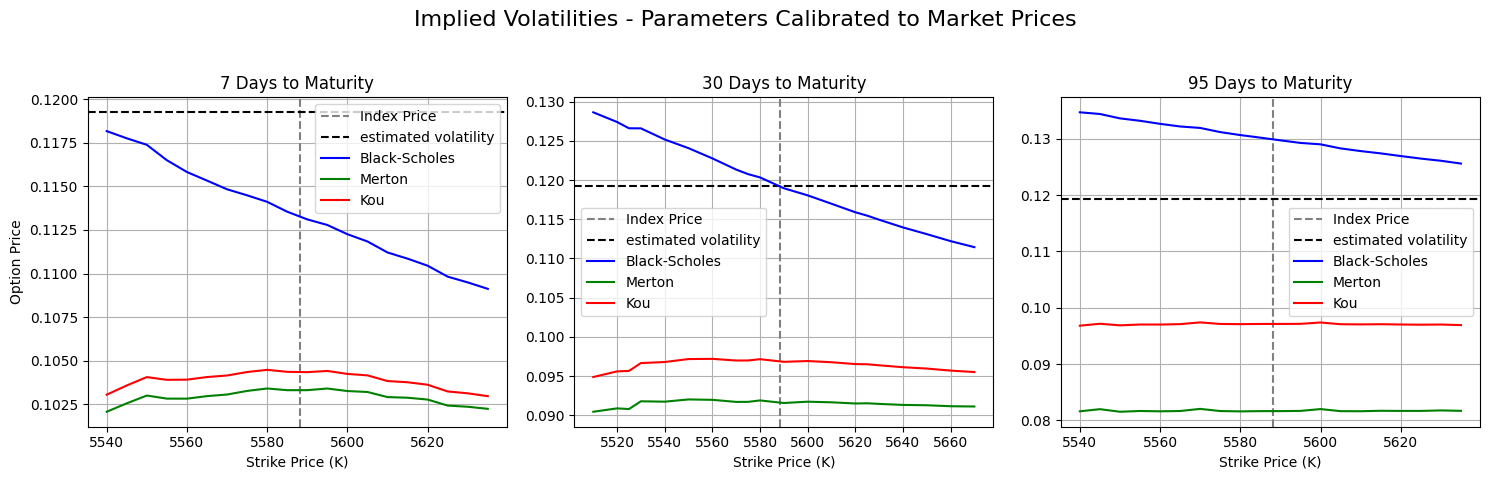

In [14]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 7 days to maturity
axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].axhline(sigma_hat, color='black', linestyle='--', label="estimated volatility")
axs[0].plot(K7, bs_iv_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_iv_7, label="Merton", color='green')
axs[0].plot(K7, kou_iv_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

# Plot for 30 days to maturity
axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].axhline(sigma_hat, color='black', linestyle='--', label="estimated volatility")
axs[1].plot(K30, bs_iv_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_iv_30, label="Merton", color='green')
axs[1].plot(K30, kou_iv_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

# Plot for 95 days to maturity
axs[2].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[2].axhline(sigma_hat, color='black', linestyle='--', label="estimated volatility")
axs[2].plot(K95, bs_iv_95, label="Black-Scholes", color='blue')
axs[2].plot(K95, merton_iv_95, label="Merton", color='green')
axs[2].plot(K95, kou_iv_95, label="Kou", color='red')
axs[2].set_title("95 Days to Maturity")
axs[2].set_xlabel("Strike Price (K)")
axs[2].legend()
axs[2].grid(True)

fig.suptitle("Implied Volatilities - Parameters Calibrated to Market Prices", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

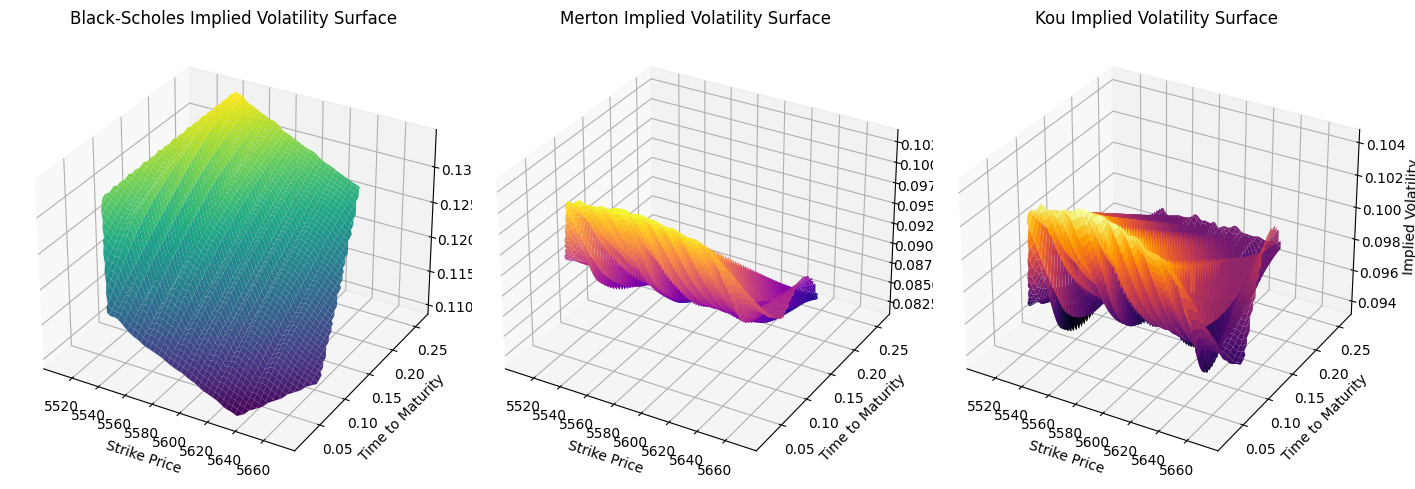

In [15]:

strikes = np.concatenate([K7, K30, K95])
maturities = np.concatenate([np.full(len(K7), 7/365, dtype=float),np.full(len(K30), 30/365, dtype=float), np.full(len(K95), 95/365, dtype=float)])

bs_iv = np.concatenate([bs_iv_7, bs_iv_30, bs_iv_95])
merton_iv = np.concatenate([merton_iv_7, merton_iv_30, merton_iv_95])
kou_iv = np.concatenate([kou_iv_7, kou_iv_30, kou_iv_95])


strike_grid, maturity_grid = np.meshgrid(np.linspace(strikes.min(), strikes.max(), 100),
                                        np.linspace(maturities.min(), maturities.max(), 100))


bs_iv_grid = griddata((strikes, maturities), bs_iv, (strike_grid, maturity_grid), method='cubic')
merton_iv_grid = griddata((strikes, maturities), merton_iv, (strike_grid, maturity_grid), method='cubic')
kou_iv_grid = griddata((strikes, maturities), kou_iv, (strike_grid, maturity_grid), method='cubic')


fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(strike_grid, maturity_grid, bs_iv_grid, cmap='viridis')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Time to Maturity')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('Black-Scholes Implied Volatility Surface')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(strike_grid, maturity_grid, merton_iv_grid, cmap='plasma')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Implied Volatility')
ax2.set_title('Merton Implied Volatility Surface')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(strike_grid, maturity_grid, kou_iv_grid, cmap='inferno')
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Time to Maturity')
ax3.set_zlabel('Implied Volatility')
ax3.set_title('Kou Implied Volatility Surface')

plt.tight_layout()
plt.show()

# Calibrating Parameters using IV

## Calibration Functions

In [16]:
def objective_function_merton(params, S, K, T, r, q, sigma, market_prices, weights):
    """Weighted objective function for Merton calibration."""
    lambd, mu_J, sigma_J = params
    if lambd <= 0 or sigma_J <= 0:
        return np.inf
    
    model_prices = merton_jump_call(S, K, T, r, q, sigma, lambd, mu_J, sigma_J)
    
    error = np.sum(weights * (model_prices - market_prices) ** 2)
    return error

def objective_function_kou(params, S, K, T, r, q, sigma, market_prices, weights):
    """Weighted objective function for Kou calibration."""
    lamb, p, eta1, eta2 = params
    if lamb <= 0 or p <= 0 or p >= 1 or eta1 <= 1 or eta2 <= 0:
        return np.inf 
    
    model_prices = kou_jump_call(S, K, T, r, q, sigma, lamb, p, eta1, eta2)
    
    error = np.sum(weights * (model_prices - market_prices) ** 2)
    return error

def calibrate_merton_params(S, K, T, r, q, sigma, market_prices, initial_guess, weights=None):
    """Hybrid calibration for Merton model."""
    if weights is None:
        weights = np.ones_like(market_prices)
    
    bounds = [
        (1e-5, 1.0),  # lambda 
        (-1.0, 1.0),    # mu_J 
        (0,1, 1.0)     # sigma_J 
    ]
    
    result_global = basinhopping(
        objective_function_merton,
        initial_guess,
        minimizer_kwargs={
            "args": (S, K, T, r, q, sigma, market_prices, weights),
            "method": "L-BFGS-B",
            "bounds": bounds,
        },
        niter=10,
        stepsize=0.1,
    )
    
    result_local = minimize(
        objective_function_merton,
        result_global.x,
        args=(S, K, T, r, q, sigma, market_prices, weights),
        method="L-BFGS-B",
        bounds=bounds,
    )
    
    return result_local.x

def calibrate_kou_params(S, K, T, r, q, sigma, market_prices, initial_guess, weights=None):
    """Hybrid calibration for Kou model."""
    if weights is None:
        weights = np.ones_like(market_prices) 
    
    sigma = np.array(sigma)
    
    bounds = [
        (1e-5, 10.0),  # lambda
        (0.01, 0.99),  # p 
        (1.01, 20.0),  # eta1 
        (1e-5, 20.0)   # eta2 
    ]
    
    result_global = basinhopping(
        objective_function_kou,
        initial_guess,
        minimizer_kwargs={
            "args": (S, K, T, r, q, sigma, market_prices, weights),
            "method": "L-BFGS-B",
            "bounds": bounds,
        },
        niter=10,
        stepsize=0.1,
    )
    
    result_local = minimize(
        objective_function_kou,
        result_global.x,
        args=(S, K, T, r, q, sigma, market_prices, weights),
        method="L-BFGS-B",
        bounds=bounds,
    )
    
    return result_local.x

## Parameter Values (Using Historically Calibrated Parameters as Initial Guesses)

In [17]:

iv_calibrated_merton_7 = calibrate_merton_params(S, K7, 7/365, r, q, merton_iv_7, c7, initial_guess_merton[1:])
iv_calibrated_kou_7 = calibrate_kou_params(S, K7, 7/365, r, q, kou_iv_7, c7, initial_guess_kou[1:])

iv_calibrated_merton_30 = calibrate_merton_params(S, K30, 30/365, r, q, merton_iv_30, c30, initial_guess_merton[1:])
iv_calibrated_kou_30 = calibrate_kou_params(S, K30, 30/365, r, q, kou_iv_30, c30, initial_guess_kou[1:])

iv_calibrated_merton_95 = calibrate_merton_params(S, K95, 95/365, r, q, merton_iv_95, c95, initial_guess_merton[1:])
iv_calibrated_kou_95 = calibrate_kou_params(S, K95, 95/365, r, q, kou_iv_95, c95, initial_guess_kou[1:])

print("7 DAY ","-"*100)
print("Kou Params:")
print("annual jump rate (λ):",iv_calibrated_kou_7[0],"\nprobability of upward jump (p):", iv_calibrated_kou_7[1], "\ninverse magnitude of upward jump (η1):", iv_calibrated_kou_7[2],"\ninverse magnitude of upward jump (η2):", iv_calibrated_kou_7[3], "\n")
print("Merton Params:")
print("annual jump rate (λ):", iv_calibrated_merton_7[0], "\nmean jump size (μJ):", iv_calibrated_merton_7[1], "\njump volatility (σJ) :",iv_calibrated_merton_7[2])

print("\n30 DAY","-"*100)
print("Kou Params:")
print("annual jump rate (λ):",iv_calibrated_kou_30[0],"\nprobability of upward jump (p):", iv_calibrated_kou_30[1], "\ninverse magnitude of upward jump (η1):", iv_calibrated_kou_30[2],"\ninverse magnitude of upward jump (η2):", iv_calibrated_kou_30[3], "\n")
print("Merton Params:")
print("annual jump rate (λ):", iv_calibrated_merton_30[0], "\nmean jump size (μJ):", iv_calibrated_merton_30[1], "\njump volatility (σJ) :",iv_calibrated_merton_30[2])

print("\n95 DAY","-"*100)
print("Kou Params:")
print("annual jump rate (λ):",iv_calibrated_kou_95[0],"\nprobability of upward jump (p):", iv_calibrated_kou_95[1], "\ninverse magnitude of upward jump (η1):", iv_calibrated_kou_95[2],"\ninverse magnitude of upward jump (η2):", iv_calibrated_kou_95[3], "\n")
print("Merton Params:")
print("annual jump rate (λ):", iv_calibrated_merton_95[0], "\nmean jump size (μJ):", iv_calibrated_merton_95[1], "\njump volatility (σJ) :",iv_calibrated_merton_95[2])

7 DAY  ----------------------------------------------------------------------------------------------------
Kou Params:
annual jump rate (λ): 0.07860427790960077 
probability of upward jump (p): 0.08445601783868804 
inverse magnitude of upward jump (η1): 9.481340417772747 
inverse magnitude of upward jump (η2): 19.81796187975214 

Merton Params:
annual jump rate (λ): 0.768431449737892 
mean jump size (μJ): -0.0835400054640658 
jump volatility (σJ) : 0.050041630993023535

30 DAY ----------------------------------------------------------------------------------------------------
Kou Params:
annual jump rate (λ): 0.1560602902241377 
probability of upward jump (p): 0.06860134179533424 
inverse magnitude of upward jump (η1): 7.413129508553969 
inverse magnitude of upward jump (η2): 19.997436281051034 

Merton Params:
annual jump rate (λ): 0.9999999366541583 
mean jump size (μJ): -0.0918482468590967 
jump volatility (σJ) : 0.049993857888507305

95 DAY ----------------------------------------

## Estimated Prices

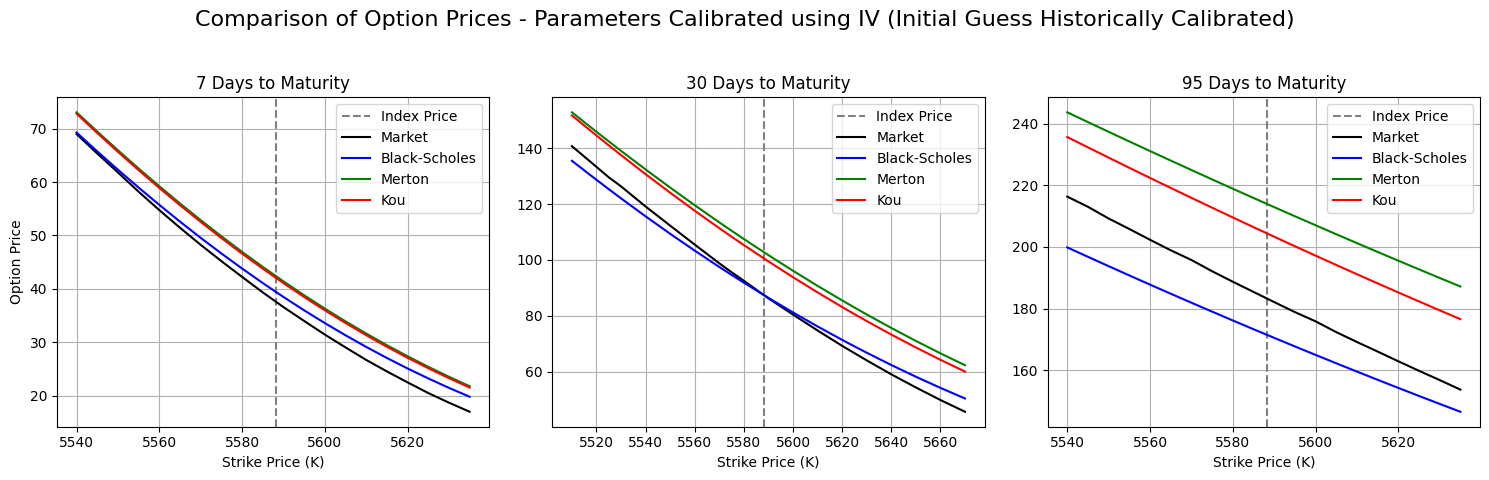

Mean Squared Errors for 7 Days:
Black-Scholes: 3.6077192370367532
Merton: 21.734898701653073
Kou: 19.019277160658365

Mean Squared Errors for 30 Days:
Black-Scholes: 10.108078651869711
Merton: 225.26283070550448
Kou: 167.82323894792597

Mean Squared Errors for 95 Days:
Black-Scholes: 149.333508297839
Merton: 934.2692375177909
Kou: 444.7256606813891


In [18]:

# Calculate prices for 7 days to maturity
bs_prices_7 = [black_scholes_call(S, k, 7/365, r, q, sigma_hat) for k in K7]
merton_prices_7 = [merton_jump_call(S, k, 7/365, r, q, sigma_hat, *iv_calibrated_merton_7) for k in K7]
kou_prices_7 = [kou_jump_call(S, k, 7/365, r, q, sigma_hat, *iv_calibrated_kou_7) for k in K7]

# Calculate prices for 30 days to maturity
bs_prices_30 = [black_scholes_call(S, k, 30/365, r, q, sigma_hat) for k in K30]
merton_prices_30 = [merton_jump_call(S, k, 30/365, r, q, sigma_hat, *iv_calibrated_merton_30) for k in K30]
kou_prices_30 = [kou_jump_call(S, k, 30/365, r, q, sigma_hat, *iv_calibrated_kou_30) for k in K30]

# Calculate prices for 95 days to maturity
bs_prices_95 = [black_scholes_call(S, k, 95/365, r, q, sigma_hat) for k in K95]
merton_prices_95 = [merton_jump_call(S, k, 95/365, r, q, sigma_hat, *iv_calibrated_merton_95) for k in K95]
kou_prices_95 = [kou_jump_call(S, k, 95/365, r, q, sigma_hat, *iv_calibrated_kou_95) for k in K95]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

# Plot for 95 days to maturity
axs[2].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[2].plot(K95, c95, label="Market", color='black')
axs[2].plot(K95, bs_prices_95, label="Black-Scholes", color='blue')
axs[2].plot(K95, merton_prices_95, label="Merton", color='green')
axs[2].plot(K95, kou_prices_95, label="Kou", color='red')
axs[2].set_title("95 Days to Maturity")
axs[2].set_xlabel("Strike Price (K)")
axs[2].legend()
axs[2].grid(True)

fig.suptitle("Comparison of Option Prices - Parameters Calibrated using IV (Initial Guess Historically Calibrated)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")

print("\nMean Squared Errors for 95 Days:")
print(f"Black-Scholes: {mean_squared_error(c95, bs_prices_95)}")
print(f"Merton: {mean_squared_error(c95, merton_prices_95)}")
print(f"Kou: {mean_squared_error(c95, kou_prices_95)}")

## Parameter Values (Using Market Price Calibrated Parameters as Intitial Guess)

In [19]:

iv_calibrated_merton_7 = calibrate_merton_params(S, K7, 7/365, r, q, merton_iv_7, c7, price_calibrated_merton_7[1:])
iv_calibrated_kou_7 = calibrate_kou_params(S, K7, 7/365, r, q, kou_iv_7, c7, price_calibrated_kou_7[1:])

iv_calibrated_merton_30 = calibrate_merton_params(S, K30, 30/365, r, q, merton_iv_30, c30, price_calibrated_merton_30[1:])
iv_calibrated_kou_30 = calibrate_kou_params(S, K30, 30/365, r, q, kou_iv_30, c30, price_calibrated_kou_30[1:])

iv_calibrated_merton_95 = calibrate_merton_params(S, K95, 95/365, r, q, merton_iv_95, c95, price_calibrated_merton_95[1:])
iv_calibrated_kou_95 = calibrate_kou_params(S, K95, 95/365, r, q, kou_iv_95, c95, price_calibrated_kou_95[1:])

print("7 DAY ","-"*100)
print("Kou Params:")
print("annual jump rate (λ):",iv_calibrated_kou_7[0],"\nprobability of upward jump (p):", iv_calibrated_kou_7[1], "\ninverse magnitude of upward jump (η1):", iv_calibrated_kou_7[2],"\ninverse magnitude of upward jump (η2):", iv_calibrated_kou_7[3], "\n")
print("Merton Params:")
print("annual jump rate (λ):", iv_calibrated_merton_7[0], "\nmean jump size (μJ):", iv_calibrated_merton_7[1], "\njump volatility (σJ) :",iv_calibrated_merton_7[2])

print("\n30 DAY","-"*100)
print("Kou Params:")
print("annual jump rate (λ):",iv_calibrated_kou_30[0],"\nprobability of upward jump (p):", iv_calibrated_kou_30[1], "\ninverse magnitude of upward jump (η1):", iv_calibrated_kou_30[2],"\ninverse magnitude of upward jump (η2):", iv_calibrated_kou_30[3], "\n")
print("Merton Params:")
print("annual jump rate (λ):", iv_calibrated_merton_30[0], "\nmean jump size (μJ):", iv_calibrated_merton_30[1], "\njump volatility (σJ) :",iv_calibrated_merton_30[2])

print("\n95 DAY","-"*100)
print("Kou Params:")
print("annual jump rate (λ):",iv_calibrated_kou_95[0],"\nprobability of upward jump (p):", iv_calibrated_kou_95[1], "\ninverse magnitude of upward jump (η1):", iv_calibrated_kou_95[2],"\ninverse magnitude of upward jump (η2):", iv_calibrated_kou_95[3], "\n")
print("Merton Params:")
print("annual jump rate (λ):", iv_calibrated_merton_95[0], "\nmean jump size (μJ):", iv_calibrated_merton_95[1], "\njump volatility (σJ) :",iv_calibrated_merton_95[2])

7 DAY  ----------------------------------------------------------------------------------------------------
Kou Params:
annual jump rate (λ): 0.032320652575721386 
probability of upward jump (p): 0.2 
inverse magnitude of upward jump (η1): 13.3277653149967 
inverse magnitude of upward jump (η2): 7.258992494080082 

Merton Params:
annual jump rate (λ): 0.7685691937740781 
mean jump size (μJ): -0.08352986551776186 
jump volatility (σJ) : 0.05001878851421268

30 DAY ----------------------------------------------------------------------------------------------------
Kou Params:
annual jump rate (λ): 0.1950284793453459 
probability of upward jump (p): 0.1998634291698503 
inverse magnitude of upward jump (η1): 19.983923519709368 
inverse magnitude of upward jump (η2): 19.999336769176942 

Merton Params:
annual jump rate (λ): 0.9999999747202045 
mean jump size (μJ): -0.09184723271073138 
jump volatility (σJ) : 0.04999832244817508

95 DAY -------------------------------------------------------

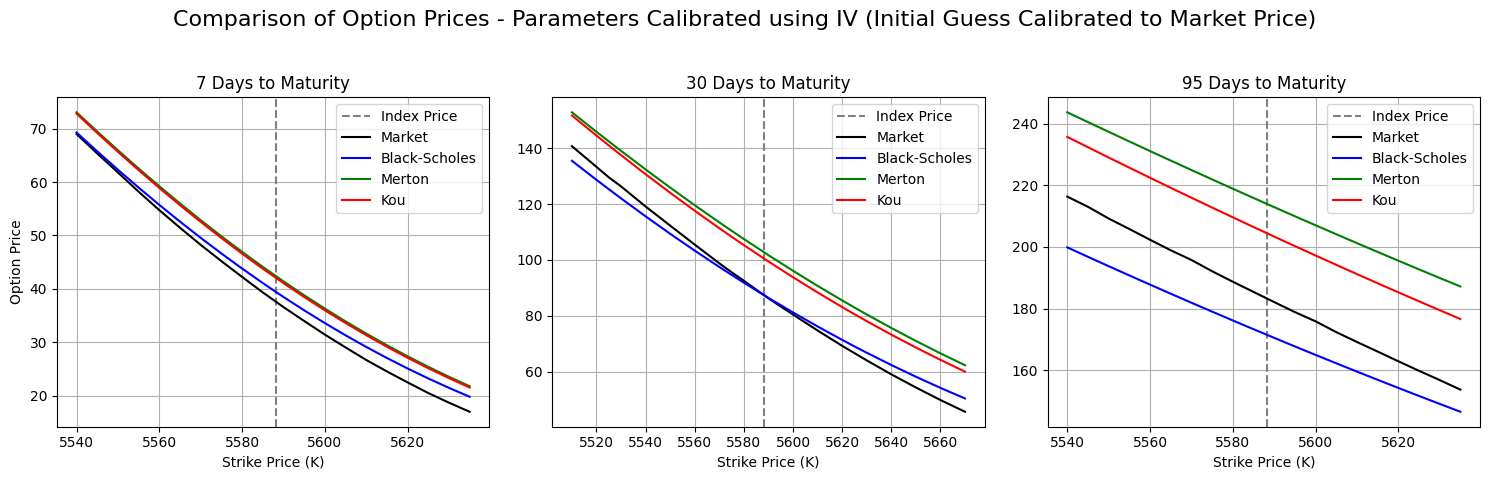

Mean Squared Errors for 7 Days:
Black-Scholes: 3.6077192370367532
Merton: 21.73474242121943
Kou: 19.044489821041836

Mean Squared Errors for 30 Days:
Black-Scholes: 10.108078651869711
Merton: 225.26387977052576
Kou: 167.41291335303123

Mean Squared Errors for 95 Days:
Black-Scholes: 149.333508297839
Merton: 934.0677370162899
Kou: 446.5097173117674


In [20]:

bs_prices_7 = [black_scholes_call(S, k, 7/365, r, q, sigma_hat) for k in K7]
merton_prices_7 = [merton_jump_call(S, k, 7/365, r, q, sigma_hat, *iv_calibrated_merton_7) for k in K7]
kou_prices_7 = [kou_jump_call(S, k, 7/365, r, q, sigma_hat, *iv_calibrated_kou_7) for k in K7]

bs_prices_30 = [black_scholes_call(S, k, 30/365, r, q, sigma_hat) for k in K30]
merton_prices_30 = [merton_jump_call(S, k, 30/365, r, q, sigma_hat, *iv_calibrated_merton_30) for k in K30]
kou_prices_30 = [kou_jump_call(S, k, 30/365, r, q, sigma_hat, *iv_calibrated_kou_30) for k in K30]

bs_prices_95 = [black_scholes_call(S, k, 95/365, r, q, sigma_hat) for k in K95]
merton_prices_95 = [merton_jump_call(S, k, 95/365, r, q, sigma_hat, *iv_calibrated_merton_95) for k in K95]
kou_prices_95 = [kou_jump_call(S, k, 95/365, r, q, sigma_hat, *iv_calibrated_kou_95) for k in K95]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

axs[2].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[2].plot(K95, c95, label="Market", color='black')
axs[2].plot(K95, bs_prices_95, label="Black-Scholes", color='blue')
axs[2].plot(K95, merton_prices_95, label="Merton", color='green')
axs[2].plot(K95, kou_prices_95, label="Kou", color='red')
axs[2].set_title("95 Days to Maturity")
axs[2].set_xlabel("Strike Price (K)")
axs[2].legend()
axs[2].grid(True)

fig.suptitle("Comparison of Option Prices - Parameters Calibrated using IV (Initial Guess Calibrated to Market Price)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculating and Printing MSEs for each maturity
print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")

print("\nMean Squared Errors for 95 Days:")
print(f"Black-Scholes: {mean_squared_error(c95, bs_prices_95)}")
print(f"Merton: {mean_squared_error(c95, merton_prices_95)}")
print(f"Kou: {mean_squared_error(c95, kou_prices_95)}")

# Out-of-Sample Testing

## Data

In [21]:
# Collected 25/08/24 19:01
S = 5634.61
imp_vol = 0.1202
hist_vol = 0.1942

K7 = [i for i in range(5535, 5730 + 1, 5)]
c7  = [111.45, 107.25, 103.45, 98.85, 94.75, 90.75, 86.75, 82.85, 78.95, 75.15, 71.45, 67.65, 64.10, 60.65, 57.20, 53.90, 50.80, 47.70, 44.65, 41.75, 38.95, 36.25, 33.65, 31.15, 28.75, 26.45, 24.35, 22.25, 20.25, 18.45, 16.70, 15.05, 13.50, 12.10, 10.80, 9.55, 8.40, 7.40, 6.50, 5.65]

K30 = [5475.00, 5480.00, 5490.00, 5500.00, 5510.00, 5520.00, 5525.00, 5530.00, 5540.00, 5550.00, 5560.00, 5570.00, 5575.00, 5580.00, 5590.00, 5600.00, 5610.00, 5620.00, 5625.00, 5630.00, 5640.00, 5650.00, 5660.00, 5670.00, 5675.00, 5680.00, 5690.00, 5700.00, 5725.00, 5750.00, 5775.00, 5800.00, 5850.00, 5900.00, 6000.00, 6100.00, 6200.00, 6300.00, 6400.00]
c30 = [209.45, 205.70, 196.85, 188.55, 180.35, 172.25, 168.25, 164.25, 156.10, 148.35, 140.75, 133.25, 129.55, 125.85, 118.70, 111.65, 104.85, 98.15, 94.95, 91.75, 85.40, 79.45, 73.65, 68.05, 65.40, 62.70, 57.75, 52.95, 42.10, 32.95, 25.40, 19.30, 10.75, 5.85, 2.00, 0.00, 0.60, 0.00, 0.00]

# IV calibrated Models

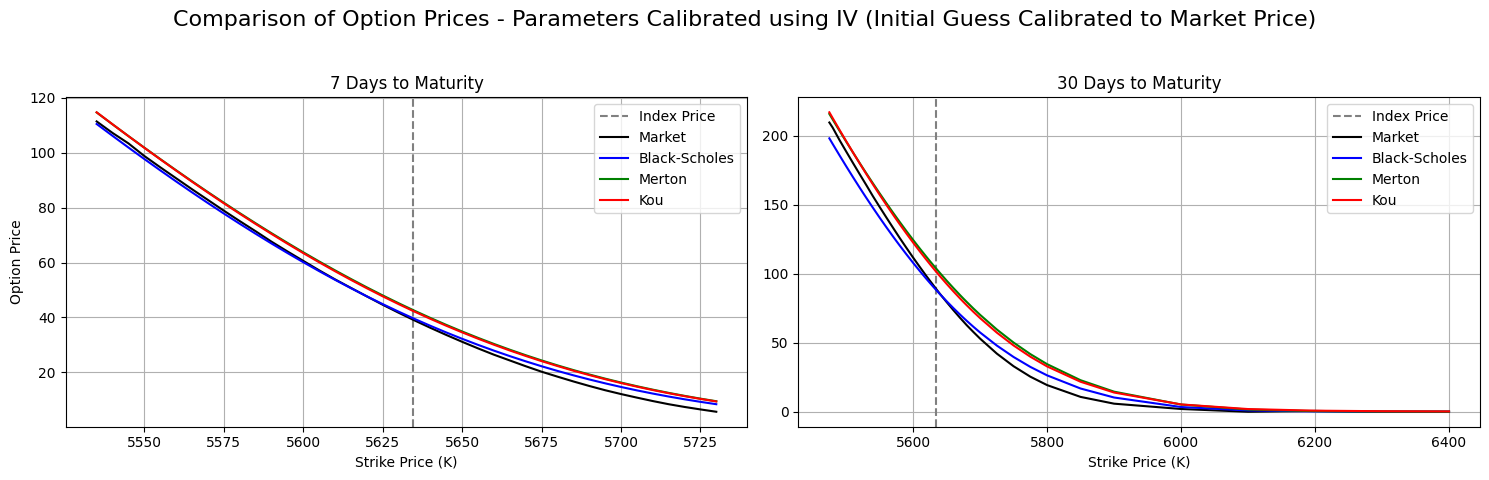

Mean Squared Errors for 7 Days:
Black-Scholes: 2.611416338744102
Merton: 12.711473440293814
Kou: 11.233546393004147

Mean Squared Errors for 30 Days:
Black-Scholes: 39.00367466597087
Merton: 145.44344458562838
Kou: 112.23868773444244


In [22]:

# IV Calibrated Market Price Initial Guess
bs_prices_7 = [black_scholes_call(S, k, 7/365, r, q, sigma_hat) for k in K7]
merton_prices_7 = [merton_jump_call(S, k, 7/365, r, q, sigma_hat, *iv_calibrated_merton_7) for k in K7]
kou_prices_7 = [kou_jump_call(S, k, 7/365, r, q, sigma_hat, *iv_calibrated_kou_7) for k in K7]

bs_prices_30 = [black_scholes_call(S, k, 30/365, r, q, sigma_hat) for k in K30]
merton_prices_30 = [merton_jump_call(S, k, 30/365, r, q, sigma_hat, *iv_calibrated_merton_30) for k in K30]
kou_prices_30 = [kou_jump_call(S, k, 30/365, r, q, sigma_hat, *iv_calibrated_kou_30) for k in K30]


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

fig.suptitle("Comparison of Option Prices - Parameters Calibrated using IV (Initial Guess Calibrated to Market Price)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculating and Printing MSEs for each maturity
print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")

## Market Price Calibrated Models

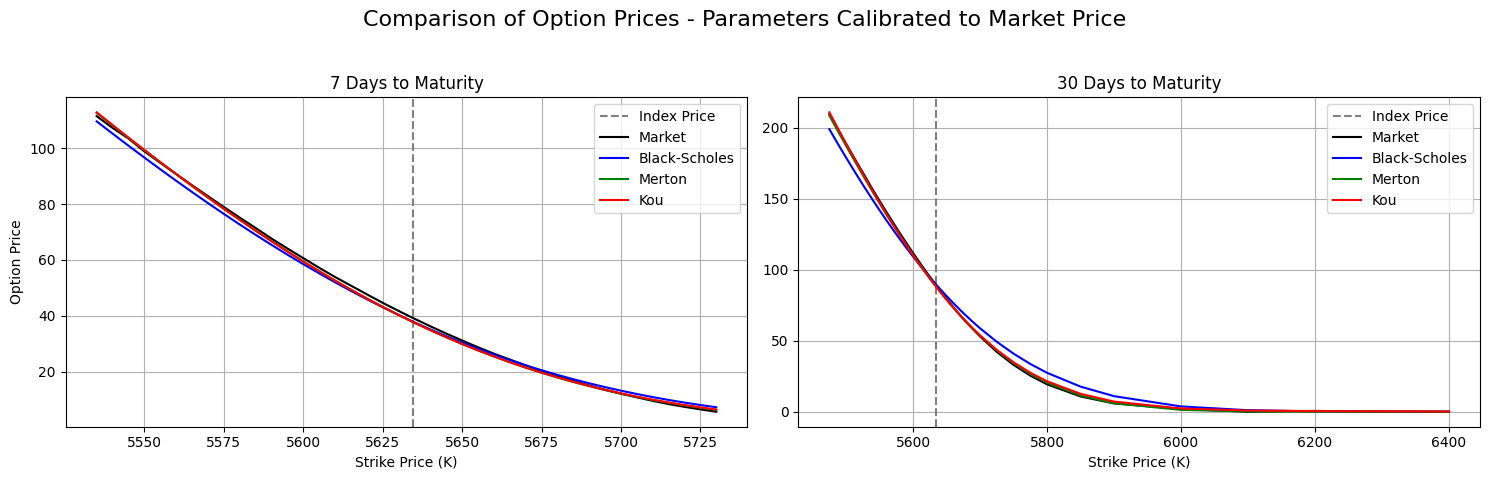

Mean Squared Errors for 7 Days:
Black-Scholes: 2.870450972686756
Merton: 0.8218751482116886
Kou: 0.8791830968285819

Mean Squared Errors for 30 Days:
Black-Scholes: 35.827378178677755
Merton: 1.3640804901199943
Kou: 1.3287490674877305


In [23]:

bs_prices_7 = [black_scholes_call(S, k, 7/365, r, q, price_calibrated_bs_7) for k in K7]
merton_prices_7 = [merton_jump_call(S, k, 7/365, r, q, *price_calibrated_merton_7) for k in K7]
kou_prices_7 = [kou_jump_call(S, k, 7/365, r, q, *price_calibrated_kou_7) for k in K7]

bs_prices_30 = [black_scholes_call(S, k, 30/365, r, q, price_calibrated_bs_30) for k in K30]
merton_prices_30 = [merton_jump_call(S, k, 30/365, r, q, *price_calibrated_merton_30) for k in K30]
kou_prices_30 = [kou_jump_call(S, k, 30/365, r, q, *price_calibrated_kou_30) for k in K30]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

fig.suptitle("Comparison of Option Prices - Parameters Calibrated to Market Price", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")

## Historical Data Calibrated Models

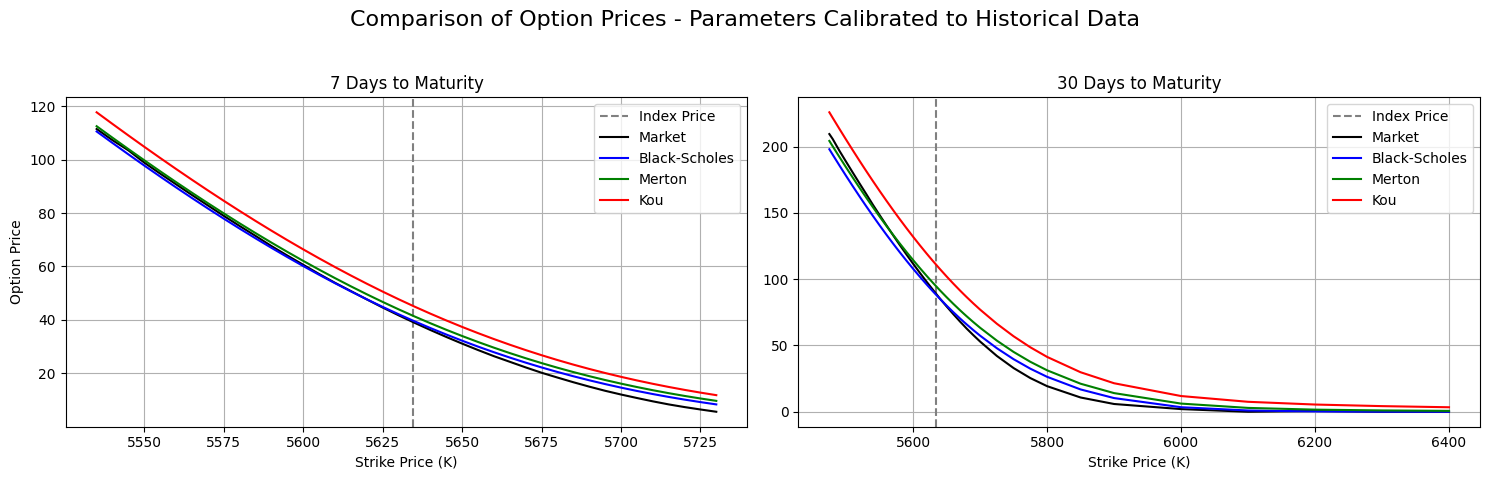

Mean Squared Errors for 7 Days:
Black-Scholes: 2.611416338744102
Merton: 7.428255187435961
Kou: 37.52939520296947

Mean Squared Errors for 30 Days:
Black-Scholes: 39.00367466597087
Merton: 41.2853604161326
Kou: 367.542990395773


In [24]:

bs_prices_7 = [black_scholes_call(S, k, 7/365, r, q, sigma_hat) for k in K7]
merton_prices_7 = [merton_jump_call(S, k, 7/365, r, q, *initial_guess_merton) for k in K7]
kou_prices_7 = [kou_jump_call(S, k, 7/365, r, q, *initial_guess_kou) for k in K7]

# Calculate prices for 30 days to maturity
bs_prices_30 = [black_scholes_call(S, k, 30/365, r, q, sigma_hat) for k in K30]
merton_prices_30 = [merton_jump_call(S, k, 30/365, r, q, *initial_guess_merton) for k in K30]
kou_prices_30 = [kou_jump_call(S, k, 30/365, r, q, *initial_guess_kou) for k in K30]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot for 7 days to maturity
axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

# Plot for 30 days to maturity
axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

fig.suptitle("Comparison of Option Prices - Parameters Calibrated to Historical Data", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculating and Printing MSEs for each maturity
print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")